# 💳 Financial Transaction Monitoring System – PySpark Edition

This PySpark-based notebook simulates 50,000+ financial transactions and applies enterprise-grade fraud detection logic including geo-anomaly detection, transaction velocity checks, and dynamic risk scoring. Built using Apache Spark to handle scale and distributed data processing.


In [1]:
import os
import sys

os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += os.pathsep + "C:\\hadoop\\bin"

# Set python executable path
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [2]:
import pyspark

# Initialize Spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lag, unix_timestamp, lit
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

In [4]:
spark

# Generate Synthetic Data

In [5]:
import random
from datetime import datetime, timedelta
import pandas as pd

cities = ['Delhi', 'Mumbai', 'New York', 'Tokyo', 'Berlin']
merchants = ['Amazon', 'Walmart', 'Netflix', 'Uber', 'Zomato']

def generate_transaction():
    return {
        'transaction_id': f'TXN{random.randint(100000, 999999)}',
        'timestamp': datetime.now() - timedelta(minutes=random.randint(0, 43200)),
        'account_id': f'ACC{random.randint(1000, 9999)}',
        'merchant': random.choice(merchants),
        'amount': round(random.uniform(10, 15000), 2),
        'location': random.choice(cities)
    }

df_pd = pd.DataFrame([generate_transaction() for _ in range(50000)])
df_spark = spark.createDataFrame(df_pd)
df_spark = df_spark.withColumn("timestamp", col("timestamp").cast("timestamp"))
df_spark.show(5)

+--------------+--------------------+----------+--------+--------+--------+
|transaction_id|           timestamp|account_id|merchant|  amount|location|
+--------------+--------------------+----------+--------+--------+--------+
|     TXN352376|2025-04-07 10:55:...|   ACC1622|  Zomato| 5615.51|   Tokyo|
|     TXN856384|2025-04-23 05:13:...|   ACC8643|    Uber|10549.86|New York|
|     TXN706114|2025-04-30 04:38:...|   ACC4973| Netflix| 6272.63|  Berlin|
|     TXN539249|2025-04-27 19:25:...|   ACC6708|  Amazon|12705.28|  Berlin|
|     TXN764894|2025-04-19 11:14:...|   ACC7655| Netflix|12243.79|New York|
+--------------+--------------------+----------+--------+--------+--------+
only showing top 5 rows



# Add Lag Columns for Previous Location + Time

In [6]:
window = Window.partitionBy("account_id").orderBy("timestamp")

df_spark = df_spark \
    .withColumn("prev_location", lag("location").over(window)) \
    .withColumn("prev_time", lag("timestamp").over(window)) \
    .withColumn("time_diff_min", 
        (unix_timestamp("timestamp") - unix_timestamp("prev_time")) / 60
    )

# Define Fraud Rules + Risk Score

In [7]:
df_spark = df_spark \
    .withColumn("geo_anomaly", 
        when(
            (col("location") != col("prev_location")) & (col("time_diff_min") < 10), lit(True)
        ).otherwise(lit(False))
    ) \
    .withColumn("risk_score", 
        when(col("amount") > 5000, 30).otherwise(0) +
        when(~col("location").isin("Delhi", "Mumbai"), 30).otherwise(0) +
        when(col("geo_anomaly") == True, 40).otherwise(0)
    )

# Show High-Risk Transactions

In [8]:
high_risk = df_spark.filter(col("risk_score") > 70).cache()
#print(f"🚨 High-Risk Transaction Count: {high_risk.count()}")
high_risk.select("transaction_id", "account_id", "location", "amount", "risk_score").show(5)

+--------------+----------+--------+--------+----------+
|transaction_id|account_id|location|  amount|risk_score|
+--------------+----------+--------+--------+----------+
|     TXN675353|   ACC6545|New York| 9347.58|       100|
|     TXN149526|   ACC2675|   Tokyo|  8314.0|       100|
|     TXN353513|   ACC9659|New York|13556.22|       100|
|     TXN947494|   ACC1960|   Tokyo|13679.58|       100|
|     TXN559460|   ACC8421|New York| 6640.63|       100|
+--------------+----------+--------+--------+----------+
only showing top 5 rows



# Save to CSV (Simulate Redshift/Snowflake Ingestion)

In [9]:
high_risk.coalesce(1).write.csv("high_risk_transactions_output", header=True, mode="overwrite")
print("✅ High-risk transactions saved to 'high_risk_transactions_output/'")

✅ High-risk transactions saved to 'high_risk_transactions_output/'


# (Optional) Convert for Matplotlib Graphing (via Pandas)

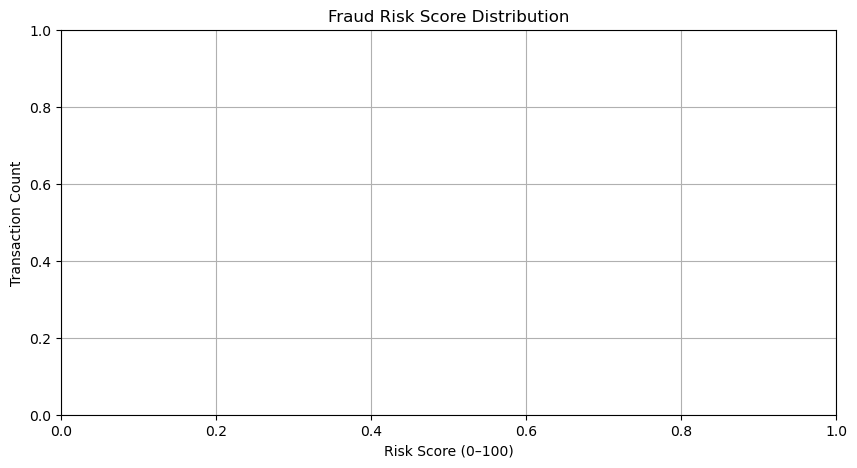

In [11]:
df_plot = df_spark.select("risk_score").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Fraud Risk Score Distribution")
plt.xlabel("Risk Score (0–100)")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.show()

## ✅ Conclusion

- 50,000+ transactions simulated in-memory and converted to Spark DataFrame
- Advanced rule-based fraud scoring logic applied (geo-anomaly, velocity, cross-border)
- Risk scoring model (0–100) generated and filtered
- Saved high-risk results for dashboarding or alert integration
- Ready for pipeline orchestration using Spark on AWS Glue, EMR, or Databricks
